In [82]:
import pandas as pd
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from nltk import pos_tag, word_tokenize
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [83]:
max_word = 50000
output_dim = 156
output_length = 200
batch_size = 16

df = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')


#adding discourse_type and discourse_text with a classification seprator. 

text = df['discourse_type'] +"  CLS " + df['discourse_text']
text = text.to_list() #getting text into a list 
y = df.discourse_effectiveness
one = OneHotEncoder(sparse=False) # applying one hot encoding for label
y = one.fit_transform(y.values.reshape(-1, 1))
#train test split
X_train, X_test, y_train, y_test = train_test_split(text, y, test_size=0.20, random_state=42,shuffle=True)

In [84]:
X_train = tf.constant(X_train)
X_test = tf.constant(X_test) 
y_train = tf.constant(y_train)
y_test= tf.constant(y_test)

In [85]:

#adding tokenization layer, 
tokenizer = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=max_word, 
                                                                         output_sequence_length=output_length)
#adding training dataset into tokens. 
tokenizer.adapt(X_train)


#creating layers. TF using word2vec for embedidng, we can use gensim also. 
embed = tf.keras.layers.Embedding(input_dim = max_word,output_dim=output_dim)

#input layer setup, we need to drfine data type here. 
inputs= tf.keras.layers.Input(shape = (1,), dtype=tf.string)
#passing input data to tokens. here we have setup tokens earlier, here we will assign tokens only
tokens = tokenizer(inputs)
#passing tokens to embedding 
embedding = embed(tokens)
#passing embedding to LSTM layer. here we using return_state and return_sequence to True
layer_1,_,_ = tf.keras.layers.LSTM(units = 10,return_sequences=True,return_state=True,activation='relu')(embedding)
layer_2,_,_ = tf.keras.layers.LSTM(units = 10,return_sequences=True,return_state=True,
                                   activation='relu')(layer_1)
layer_3,_,_ = tf.keras.layers.LSTM(units=10,activation='relu',return_sequences=True,return_state=True)(layer_2)
#we need to flatten our layer to pass data to Dense layer for prediction. 
flatten = tf.keras.layers.Flatten()(layer_3)
output = tf.keras.layers.Dense(3,activation = 'softmax')(flatten)

#model setup.
model = tf.keras.Model(inputs,output)

In [96]:
opt = tf.keras.optimizers.Adam()
loss = tf.keras.losses.categorical_crossentropy
mean_loss = tf.keras.metrics.Mean()

In [ ]:
epochs = 3
start = 0 
grads = []
for epoch in range(epochs):
    start = 0
    end = batch_size
    for i in tqdm(range(0,len(X_train)//batch_size)):
    #for i in tqdm(range(0,10)):
        X_batch = X_train[start:end]
        y_batch = y_train[start:end]
        start = start+batch_size
        end = end+batch_size
        with tf.GradientTape() as tape:
            
            y_preds = model(X_batch)
            loss_ = loss(y_preds,y_batch)
            loss_ += sum(model.losses)
        grad = tape.gradient(loss_,model.trainable_variables)
        opt.apply_gradients(zip(grad, model.trainable_variables))
        grads.append(grad)
    print(mean_loss(loss_).numpy())

 11%|█         | 205/1838 [05:32<43:10,  1.59s/it]

# Weights 

In [109]:
len(model.trainable_weights)

12

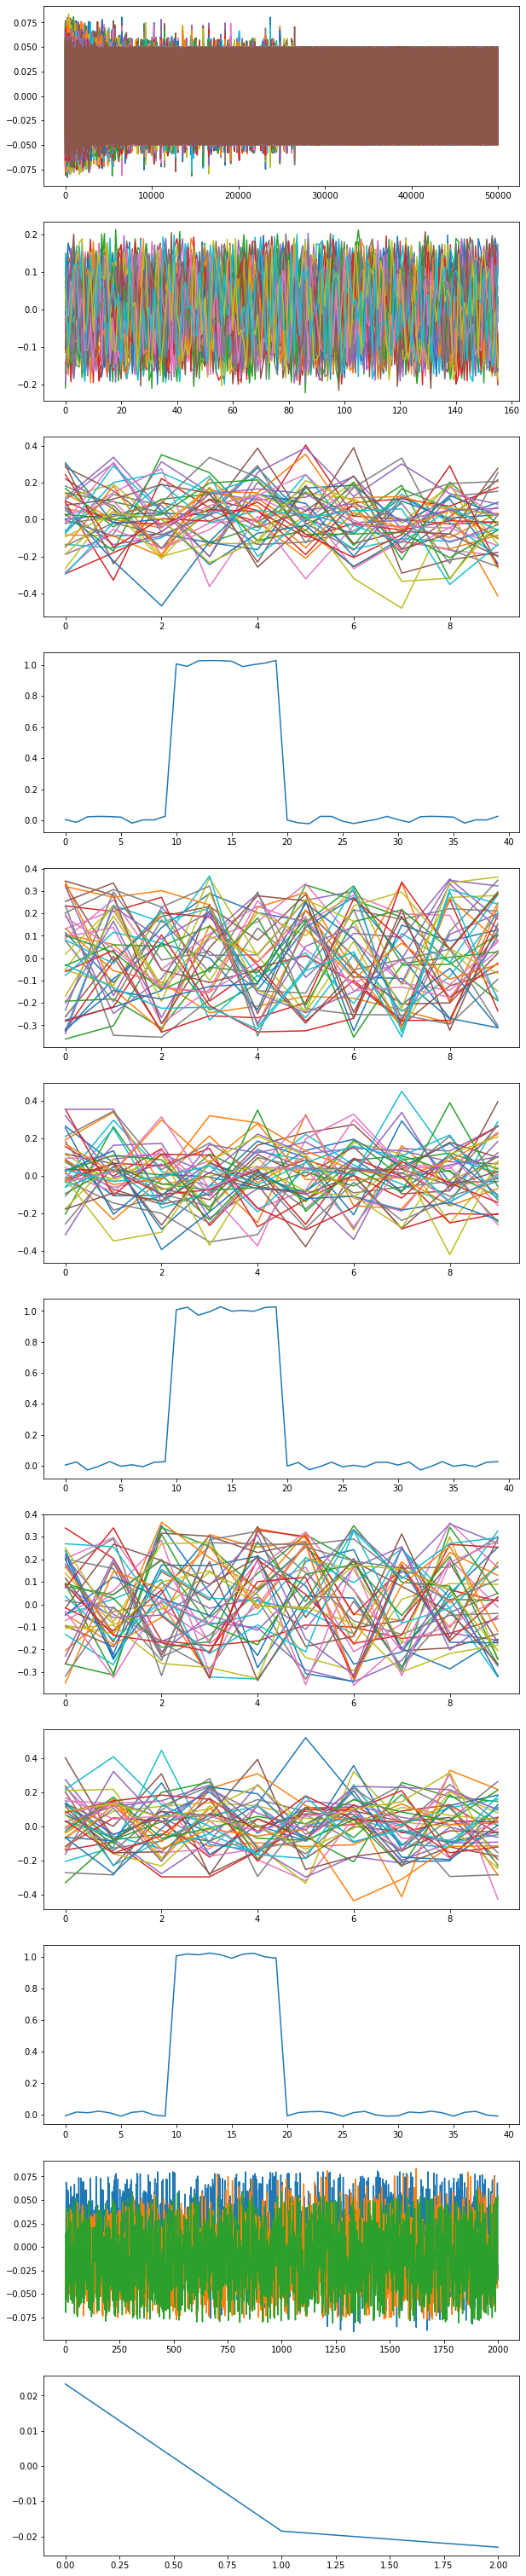

In [110]:
n =1
plt.subplots(12,1,figsize = (10,55))
for i in range(len(model.trainable_weights)):
    plt.subplot(12,1,n)
    plt.plot(model.trainable_weights[i].numpy())
    n = n+1    
plt.show()

# Gradients for last layer

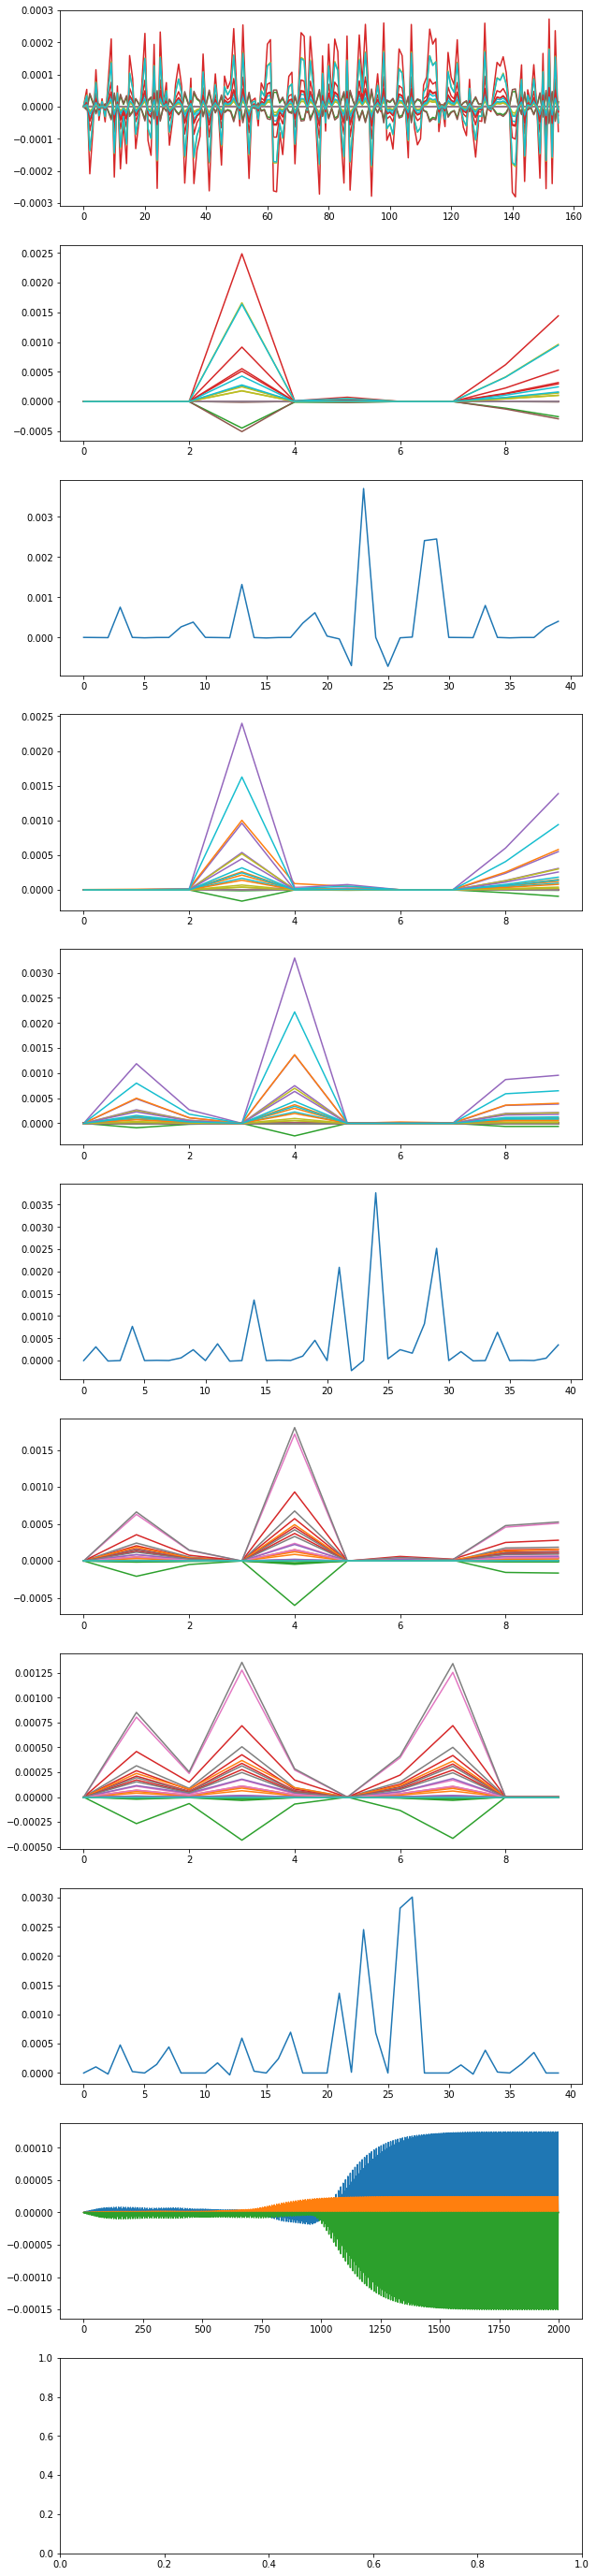

In [143]:
n =1
plt.subplots(11,1,figsize = (10,50))
for i in range(1,len(grads[0][1:])):
    plt.subplot(11,1,n)
    plt.plot(grads[0][i].numpy())
    n = n+1
#plt.show()
    
plt.show()